In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [25]:
def exp_func(x, a, b, c, d):
    return a * np.exp(b * (x-c)) + d

def sigmoid(x, a, b, c, d):
    return a / (1 + np.exp(-b*(x-c)) + d)

In [26]:
countries = ['Germany', 'France', 'Australia', 'Brazil', 'Italy', 'Spain',
       'Canada', 'Netherlands', 'Switzerland', 'India', 'Sweden',
       'South Africa', 'Mexico', 'Japan', 'Belgium', 'Russia', 'Poland',
       'Portugal', 'Finland', 'Czech Republic', 'Denmark', 'New Zealand',
       'Austria', 'Argentina', 'Norway', 'Indonesia', 'Chile', 'Colombia',
       'Israel', 'Costa Rica', 'Peru', 'Estonia', 'Croatia', 'Ukraine',
       'Puerto Rico']

In [27]:
# get the citation data

paper_df_list = []
biodiversity_research_df_list = []

for country in countries:
    biodiversity_research_df = pd.read_csv(f'Final_project_raw_data/{country}_biodiversity_research.csv')
    biodiversity_research_df_list.append(biodiversity_research_df)
    citations = np.array(biodiversity_research_df['Times Cited, All Databases'], dtype='int')
    pub_years = np.array(biodiversity_research_df['Publication Year'], dtype='int')
    paper_ages = 2022 - pub_years
    paper_df = pd.DataFrame(dict({'Paper Age': paper_ages, 'Citations': citations}))
    paper_df = paper_df[paper_df['Paper Age'] <= 25]
    paper_df = paper_df.reset_index(drop=True)
    paper_df_list.append(paper_df)

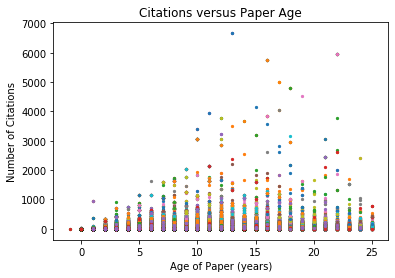

In [28]:
# plot the age of each paper and its citation counts

for country, paper_df in zip(countries, paper_df_list):

    plt.scatter(paper_df['Paper Age'], paper_df['Citations'], s=5)
    plt.xlabel('Age of Paper (years)')
    plt.ylabel('Number of Citations')
    plt.title(f'Citations versus Paper Age')

Analysis for sigmoid function

In [29]:
popt_list_sig = []
for country, paper_df in zip(countries, paper_df_list):
    popt, pcov = curve_fit(sigmoid, paper_df['Paper Age'], paper_df['Citations'], bounds=(0, np.inf), maxfev=5000)
    popt_list_sig.append(popt)

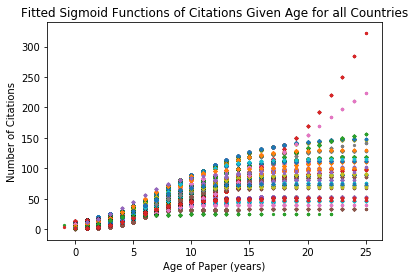

In [30]:
for country, popt, paper_df in zip(countries, popt_list_sig, paper_df_list):
    plt.scatter(paper_df['Paper Age'], sigmoid(paper_df['Paper Age'], *popt), label=country, s=5)
    #plt.legend()
    plt.xlabel('Age of Paper (years)')
    plt.ylabel('Number of Citations')
    plt.title(f'Fitted Sigmoid Functions of Citations Given Age for all Countries')
    
plt.show()

Analysis for exponential function

In [31]:
popt_list_exp = []
for country, paper_df in zip(countries, paper_df_list):
    popt, pcov = curve_fit(exp_func, paper_df['Paper Age'], paper_df['Citations'], bounds=(0, np.inf), maxfev=5000)
    popt_list_exp.append(popt)

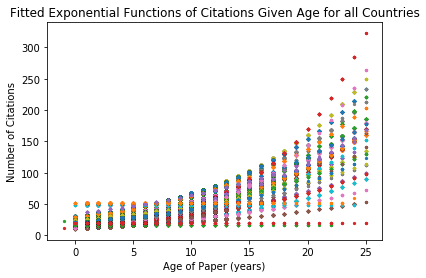

In [32]:
for country, popt, paper_df in zip(countries, popt_list_exp, paper_df_list):
    plt.scatter(paper_df['Paper Age'], exp_func(paper_df['Paper Age'], *popt), label=country, s=5)
    #plt.legend()
    plt.xlabel('Age of Paper (years)')
    plt.ylabel('Number of Citations')
    plt.title(f'Fitted Exponential Functions of Citations Given Age for all Countries')
    
plt.show()

In [33]:
paper_df_list[0]

,Paper Age,Citations
0,9,477
1,12,456
2,8,454
3,18,449
4,7,465
...,...,...
15355,2,2
15356,2,2
15357,2,2
15358,2,2


Error analysis to compare fits

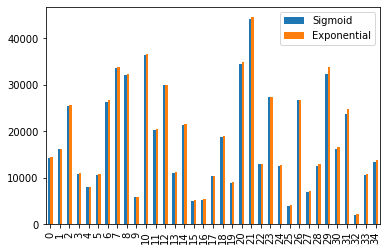

In [34]:
from sklearn.metrics import mean_squared_error

err_df = pd.DataFrame()
err_df['Country'] = countries

err_sig = []
err_exp = []

for popt_sig, popt_exp, paper_df in zip(popt_list_sig, popt_list_exp, paper_df_list):
    ages = paper_df['Paper Age']
    cit_true = paper_df['Citations']
    cit_pred_sig = sigmoid(ages, *popt_sig)
    cit_pred_exp = exp_func(ages, *popt_exp)
    
    err_sig.append(mean_squared_error(cit_true,cit_pred_sig))
    err_exp.append(mean_squared_error(cit_true,cit_pred_exp))

err_df['Sigmoid'] = err_sig
err_df['Exponential'] = err_exp



err_df.plot.bar()
#plt.bar(countries,err_exp)

Obviously very high error but sigmoid function does a better job at fitting the data than the exponential for every country!!

In [35]:
# normalize the paper citations by this factor
for popt, biodiversity_research_df in zip(popt_list_sig, biodiversity_research_df_list):
        biodiversity_research_df['Adjusted Citations'] = biodiversity_research_df['Times Cited, All Databases'] / sigmoid(2022 - biodiversity_research_df['Publication Year'], *popt)

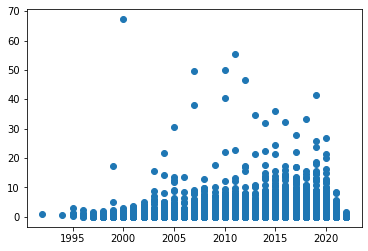

In [36]:
plt.scatter(biodiversity_research_df_list[0]['Publication Year'], biodiversity_research_df_list[0]['Adjusted Citations'])

In [37]:
# export function info for each country to .csv file
popt_arr = np.asarray(popt_list_sig)

adjusted_citations_df = pd.DataFrame()
adjusted_citations_df['Country'] = countries
adjusted_citations_df['a'] = popt_arr[:,0]
adjusted_citations_df['b'] = popt_arr[:,1]
adjusted_citations_df['c'] = popt_arr[:,2]
adjusted_citations_df['d'] = popt_arr[:,3]
adjusted_citations_df.to_csv('adjusted_citations_sigmoid_params.csv')
adjusted_citations_df

,Country,a,b,c,d
0,Germany,89.037550,0.354018,7.092121,6.778228e-04
1,France,100.843242,0.309800,8.347899,1.162299e-02
2,Australia,143.916941,0.287474,9.370554,1.956695e-01
3,Brazil,101.681352,0.255176,11.066316,1.589457e-02
4,Italy,53.411444,0.509816,5.108911,1.779886e-02
5,Spain,86.380016,0.336436,7.672176,8.025689e-03
6,Canada,112.960848,0.337377,8.054154,1.387538e-03
7,Netherlands,129.574626,0.323556,7.755634,8.729628e-04
8,Switzerland,149.129529,0.280598,9.053448,6.167551e-04
9,India,47.117108,0.454146,6.202835,2.654992e-02


In [38]:
def flatten_strip(list):
    # remove extra space around each element in the input list
    return [i.strip() for i in list]

In [39]:
def a_big_one(raw_data,column_name):
    row_before_dropna = raw_data.shape[0] 
    
    cleaned_data = raw_data.dropna(axis=0, subset=[column_name])# delete the row with nan in this column
    row_after_dropna = cleaned_data.shape[0] 
    cleaned_data = cleaned_data.reset_index()
    
    org_nation = {}
    temp_dicts_key_author=[]
    
    for i in range(len(raw_data)):
        string = cleaned_data.loc[i, column_name]

        state = -1

        temp_authors = ''
        temp_adds = ''

        temp_name = []
        temp_country = ''

        temp_dict_key_author={}
        temp_dict_key_org={}

        for s in string:
            if s == '[':
                state = 0
            elif s == ']':
                state = 1
            elif state == 1 and s == ';':
                state = 2

            if state == 0:
                temp_authors+=s
            elif state == 1:
                temp_adds+=s
            elif state == 2 and temp_authors:

                auth = flatten_strip(temp_authors[1:].split(';'))

                add = flatten_strip(temp_adds[2:].split(','))

                org = add[0]


                nation = add[-1].split(' ')[-1]

                temp_authors,temp_adds='',''
                if org not in org_nation.keys():
                    org_nation[org] = nation

                for author in auth:
                    if author in temp_dict_key_author.keys():
                        if (org,org_nation[org]) not in temp_dict_key_author[author]:
                            temp_dict_key_author[author].append((org,org_nation[org]))
                    else:
                        temp_dict_key_author[author] = [(org,org_nation[org])]

        temp_dicts_key_author.append(temp_dict_key_author)
        
    author_num_for_each_country_by_paper =[]
    for paper in temp_dicts_key_author:
        author_num_for_each_country_by_paper.append({})
        for author in paper.keys():
            adds = paper[author]
            for add in adds:
                if add[-1] not in author_num_for_each_country_by_paper[-1].keys():
                    author_num_for_each_country_by_paper[-1][add[-1]] = 1
                else:
                    author_num_for_each_country_by_paper[-1][add[-1]]+=1
                    
                    
    dif_org_for_each_country_by_paper =[]
    for paper in temp_dicts_key_author:
        dif_org_for_each_country_by_paper.append({})
        for author in paper.keys():
            adds = paper[author]
            for add in adds:
                if add not in dif_org_for_each_country_by_paper[-1].keys():
                    dif_org_for_each_country_by_paper[-1][add] = 1
                else:
                    dif_org_for_each_country_by_paper[-1][add]+=1

    return author_num_for_each_country_by_paper,dif_org_for_each_country_by_paper,org_nation

In [40]:
def get_org_counts(dif_org_for_each_country_by_paper, country_str):
    org_counts = []
    for index, paper_dict in enumerate(dif_org_for_each_country_by_paper):
        org_count = 0
        for key in dif_org_for_each_country_by_paper[index].keys():
            if country_str in key:
                org_count += 1
        org_counts.append(org_count)
    return org_counts

def get_author_counts(author_num_for_each_country_by_paper, country_str):
    author_counts = []
    for index, paper_dict in enumerate(author_num_for_each_country_by_paper):
        author_count = 0
        for key in author_num_for_each_country_by_paper[index].keys():
            if country_str in key:
                author_count += author_num_for_each_country_by_paper[index][key]
        author_counts.append(author_count)
    return author_counts

In [41]:
# read in each country dataframe and perform feature engineering

protected_df = pd.read_csv('Final_project_raw_data/protected_land_cleaned.csv')
param_df = pd.read_csv('adjusted_citations_sigmoid_params.csv')
param_df = param_df.drop(['Unnamed: 0', 'Country'], axis=1)
param_array = param_df.to_numpy()

for popt,country_str in zip(param_array, countries):
    
    # new dataframe to contain only relevant variables
    country_research_df_new = pd.DataFrame()
    
    country_research_df = pd.read_csv(f"Final_project_raw_data/{country_str}_biodiversity_research.csv")
    country_research_df['Paper Age'] = 2022 - country_research_df['Publication Year']
    
    # adding variables to new dataframe
    country_research_df_new['Publication Year'] = country_research_df['Publication Year']
    country_research_df_new['Paper Age'] = country_research_df['Paper Age']
    country_research_df_new['Addresses'] = country_research_df['Addresses']
    
    # adding adjusted citation metric
    country_research_df_new['Adjusted Citations'] = country_research_df['Times Cited, All Databases'] / sigmoid(country_research_df['Paper Age'], *popt)
    # getting author and organization count metrics
    author_num_for_each_country_by_paper,dif_org_for_each_country_by_paper,org_nation = a_big_one(country_research_df, 'Addresses')
    
    mod_string = country_str
    if country_str == 'United States':
        mod_string = 'USA'
    elif country_str == "China (People's Republic of)":
        mod_string = 'China'
        
    author_counts = get_author_counts(author_num_for_each_country_by_paper, mod_string)
    org_counts = get_org_counts(dif_org_for_each_country_by_paper, mod_string)
    
    # number of authors from given country per paper
    country_research_df_new['Country Specific Authors'] = author_counts
    
    # number of organizations in a given country per paper
    country_research_df_new['Country Specific Orgs'] = org_counts
    
    # write new research df to file
    country_research_df_new.to_csv(f"{country_str}_biodiversity_research_sigmoid.csv")

C:\Users\freja\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\freja\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (12,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\freja\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\freja\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (11,15,50,53) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=re